In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

trainL = ImageDataset(dataset=datasets.TRAINING_LABELED_80,network_input_size=256, cuda=cuda, normalize=True)
trainU = ImageDataset(dataset=datasets.TRAINING_UNLABELED,network_input_size=256, cuda=cuda, normalize=True)
trainC = ConcatDataset([trainL,trainU])

In [7]:
train_size = int(0.8*len(trainC))
val_size = len(trainC)-train_size
train,val = random_split(trainC,[train_size,val_size])
test = ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda, normalize=True)
valL = ImageDataset(dataset=datasets.VALIDATION_LABELED_20,network_input_size=256,cuda=cuda, normalize=True)

trainL = DataLoader(trainL,64,True)
train = DataLoader(train,64,True)
val = DataLoader(val,64,True)
test = DataLoader(test,64,True)
valL = DataLoader(valL,64,True)

In [8]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: 64 x 128 x 128

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size: 128 x 64 x 64

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 256 x 32 x 32
        )
        # Decoder: Deconvolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),  # Output 2 channels (a, b)
            nn.Tanh()  # Normalize output to range [-1, 1]
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

In [9]:
best_model_path = 'self-supervised/models/best_Colorizer.pth'
colorizer = ColorizationModel()
colorizer.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [10]:
class ExtendedColorizer(nn.Module):
    def __init__(self, colorizer):
        super(ExtendedColorizer, self).__init__()
        self.encoder = colorizer.encoder
        self.ff1 = nn.Linear(256*32*32, 1024)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(1024, 251)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        for param in self.encoder.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256*32*32)
        x = self.ff1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.ff2(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [10]:
from torchvision.transforms import v2

augment = v2.RandomApply([
    v2.RandomHorizontalFlip(1),
    v2.RandomVerticalFlip(1),
    v2.RandomRotation(30),
    v2.RandomAffine(0, translate=(0.1,0.1)),
    v2.RandomResizedCrop(256,scale=(0.8,1.0)),
    v2.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0),
    v2.GaussianBlur(3, sigma=(0.1, 2.0)),
    v2.GaussianNoise(0.01),
    v2.RandomEqualize()
])

In [11]:
def show_image(image):
    """
    Function to display an image using matplotlib.pyplot
    :param image: Input image (numpy array or torch tensor)
    """
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()
def renormalize(tensor):
    minFrom = tensor.min()
    maxFrom = tensor.max()
    minTo = 0
    maxTo = 1
    return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))

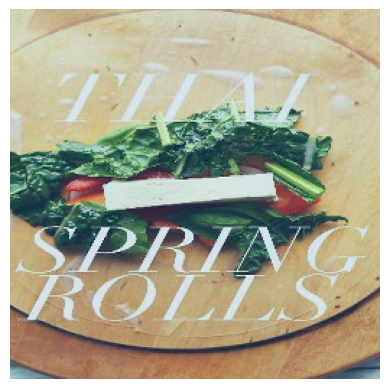

In [111]:
batch = next(iter(train))[0]
batch = augment(batch)
show_image(renormalize(batch[0]))


In [12]:
def process_batch(batch):
    batch = batch.cpu().numpy()
    batch = np.moveaxis(batch, 1, -1)  # Move channel axis to the end
    lab_batch = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2LAB) for img in batch])
    
    L_batch = lab_batch[:,:,:,0] / 255.0
    ab_batch = lab_batch[:,:,:,1:] / 128.0
    
    L_batch = torch.tensor(L_batch, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    ab_batch = torch.tensor(ab_batch, dtype=torch.float32).permute(0, 3, 1, 2)  # Move channel axis to the second position
    
    return L_batch, ab_batch

In [116]:
exColorizer = ExtendedColorizer(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-6)
best_model_path = 'self-supervised/models/best_Augmented_Colorizer_classifier.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        inputs = augment(inputs)
        inputs,_ = process_batch(inputs)
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.525465586828807, Accuracy: 0.2739043824701195%
Validation:
Batch 10 di 16
Validation Loss: 5.525442868471146, Accuracy: 0.398406374501992%
Best model saved with validation loss: 5.525442868471146
Epoch: 2
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.525367388649593, Accuracy: 0.5229083665338645%
Validation:
Batch 10 di 16
Validation Loss: 5.525429755449295, Accuracy: 0.5976095617529881%
Best model saved with validation loss: 5.525429755449295
Epoch: 3
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.525226926046704, Accuracy: 0.5727091633466136%
Validation:
Batch 10 di 16
Validation Loss: 5.525397390127182, Accuracy: 0.6972111553784861%
Best model saved with validation loss: 5.525397390127182
Epoch: 4
Training:
Batch 10 di 6

KeyboardInterrupt: 

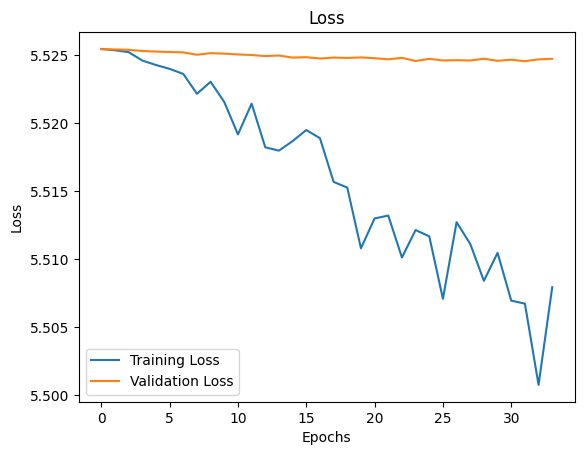

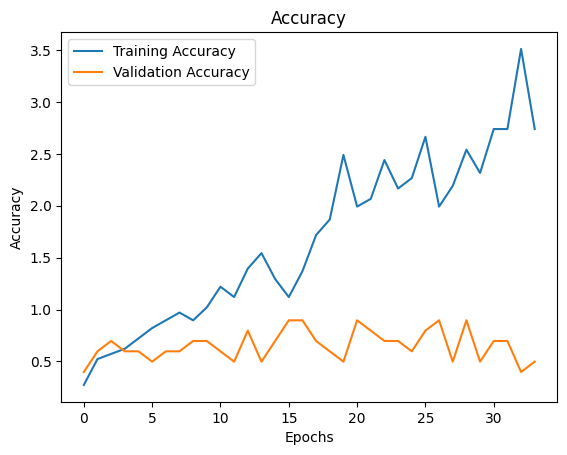

In [117]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)

In [13]:
class ExtendedColorizerLinear(nn.Module):
    def __init__(self, colorizer):
        super(ExtendedColorizerLinear, self).__init__()
        self.encoder = colorizer.encoder
        self.ff1 = nn.Linear(256*32*32, 1024)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(1024, 251)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
        for param in self.encoder.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256*32*32)
        x = self.ff1(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [18]:
exColorizer = ExtendedColorizerLinear(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 100
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-6)
best_model_path = 'self-supervised/models/best_Augmented_LinearColorizer_classifier.pth'
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        inputs = augment(inputs)
        inputs,_ = process_batch(inputs)
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 6.931273354424371, Accuracy: 0.3237051792828685%
Validation:
Batch 10 di 16
Validation Loss: 6.930125683546066, Accuracy: 0.29880478087649404%
Best model saved with validation loss: 6.930125683546066
Epoch: 2
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 6.930845752594963, Accuracy: 0.5727091633466136%
Validation:
Batch 10 di 16
Validation Loss: 6.929137200117111, Accuracy: 0.49800796812749004%
Best model saved with validation loss: 6.929137200117111
Epoch: 3
Training:
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 6.930065533471486, Accuracy: 0.8715139442231076%
Validation:
Batch 10 di 16
Validation Loss: 6.928809821605682, Accuracy: 0.796812749003984%
Best model saved with validation loss: 6.928809821605682
Epoch: 4
Training:
Batch 10 di

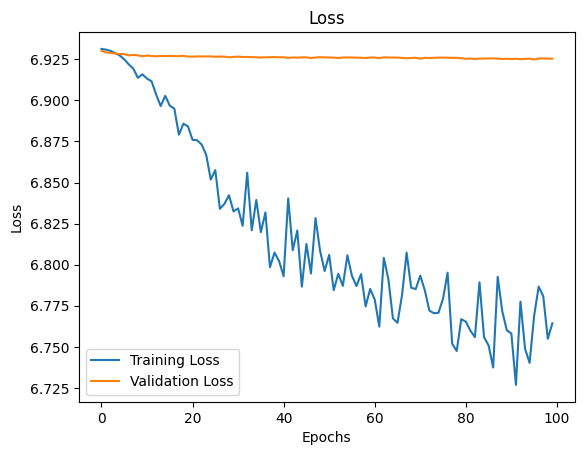

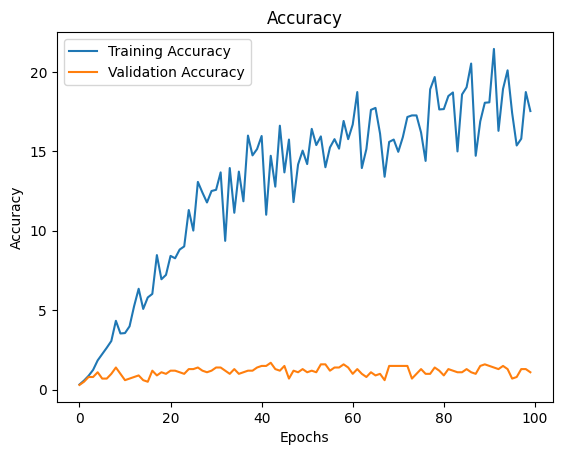

In [19]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)

In [13]:
class ExtendedColorizerLinear(nn.Module):
    def __init__(self, colorizer):
        super(ExtendedColorizerLinear, self).__init__()
        self.encoder = colorizer.encoder
        self.ff1 = nn.Linear(256*32*32, 1024)
        self.relu = nn.ReLU()
        self.ff2 = nn.Linear(1024, 251)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 256*32*32)
        x = self.ff1(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x

In [14]:
exColorizer = ExtendedColorizerLinear(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 10
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-6)
best_model_path = 'self-supervised/models/best_Augmented_LinearColorizer_classifier_NO_FREEZE.pth'
for epoch in tqdm(range(num_epochs)):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in tqdm(trainL, leave=False):
        i=i+1
        labels = [int(label) for label in labels]
        #inputs = augment(inputs)
        inputs,_ = process_batch(inputs)
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in tqdm(valL, leave = False):
            i+=1
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch: 1
Training:


100%|██████████| 63/63 [06:35<00:00,  6.27s/it]


Training Loss: 6.93127447461325, Accuracy: 0.3237051792828685%
Validation:


100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


Validation Loss: 6.930077105760574, Accuracy: 0.5976095617529881%
Best model saved with validation loss: 6.930077105760574
Epoch: 2
Training:


100%|██████████| 63/63 [05:38<00:00,  5.38s/it]


Training Loss: 6.930571003565713, Accuracy: 1.9422310756972112%
Validation:


100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


Validation Loss: 6.929147869348526, Accuracy: 0.6972111553784861%
Best model saved with validation loss: 6.929147869348526
Epoch: 3
Training:


100%|██████████| 63/63 [06:19<00:00,  6.02s/it]


Training Loss: 6.9282479513259165, Accuracy: 2.589641434262948%
Validation:


100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


Validation Loss: 6.928543299436569, Accuracy: 0.796812749003984%
Best model saved with validation loss: 6.928543299436569
Epoch: 4
Training:


100%|██████████| 63/63 [07:26<00:00,  7.09s/it]


Training Loss: 6.923902927883088, Accuracy: 4.48207171314741%
Validation:


100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


Validation Loss: 6.928174585103989, Accuracy: 1.294820717131474%
Best model saved with validation loss: 6.928174585103989
Epoch: 5
Training:


100%|██████████| 63/63 [06:41<00:00,  6.37s/it]


Training Loss: 6.915511123717777, Accuracy: 7.0717131474103585%
Validation:


100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


Validation Loss: 6.927891135215759, Accuracy: 1.095617529880478%
Best model saved with validation loss: 6.927891135215759
Epoch: 6
Training:


100%|██████████| 63/63 [05:54<00:00,  5.62s/it]


Training Loss: 6.900582881200881, Accuracy: 10.358565737051793%
Validation:


100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


Validation Loss: 6.927539497613907, Accuracy: 1.1952191235059761%
Best model saved with validation loss: 6.927539497613907
Epoch: 7
Training:


100%|██████████| 63/63 [10:16<00:00,  9.78s/it] 


Training Loss: 6.8814883383493575, Accuracy: 13.371513944223107%
Validation:


100%|██████████| 16/16 [00:23<00:00,  1.49s/it]


Validation Loss: 6.927191525697708, Accuracy: 1.4940239043824701%
Best model saved with validation loss: 6.927191525697708
Epoch: 8
Training:


100%|██████████| 63/63 [07:38<00:00,  7.27s/it]


Training Loss: 6.860691517118424, Accuracy: 16.235059760956176%
Validation:


100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


Validation Loss: 6.926932245492935, Accuracy: 1.8924302788844622%
Best model saved with validation loss: 6.926932245492935
Epoch: 9
Training:


100%|██████████| 63/63 [07:11<00:00,  6.84s/it]


Training Loss: 6.833174554128496, Accuracy: 19.621513944223107%
Validation:


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


Validation Loss: 6.926816344261169, Accuracy: 1.294820717131474%
Best model saved with validation loss: 6.926816344261169
Epoch: 10
Training:


100%|██████████| 63/63 [05:43<00:00,  5.46s/it]


Training Loss: 6.809447349063934, Accuracy: 21.339641434262948%
Validation:


100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


Validation Loss: 6.926615685224533, Accuracy: 1.6932270916334662%
Best model saved with validation loss: 6.926615685224533


In [15]:
exColorizer = ExtendedColorizerLinear(colorizer)
exColorizer.to(device)
exColorizer.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 10
best_val_loss = float('inf')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exColorizer.parameters(), lr = 1e-6)
best_model_path = 'self-supervised/models/best_Augmented_LinearColorizer_classifier_NO_FREEZE.pth'
for epoch in tqdm(range(num_epochs)):
    print(f'Epoch: {epoch+1}')
    exColorizer.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in tqdm(trainL, leave=False):
        i=i+1
        labels = [int(label) for label in labels]
        inputs = augment(inputs)
        inputs,_ = process_batch(inputs)
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exColorizer(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exColorizer.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in tqdm(valL, leave = False):
            i+=1
            labels=[int(lable) for lable in labels]
            inputs,_ = process_batch(inputs)
            inputs,labels = inputs.to(device), torch.tensor(labels,dtype=torch.long).to(device)
            outputs = exColorizer(inputs)
            _,predicted = torch.max(outputs,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs,labels)
            running_loss += loss.item()
    val_loss_epoch = running_loss / len(valL)
    print(f'Validation Loss: {val_loss_epoch}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(exColorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training:


Training Loss: 6.931233254690019, Accuracy: 0.2739043824701195%
Validation:


Validation Loss: 6.9299648106098175, Accuracy: 0.398406374501992%


 10%|█         | 1/10 [14:54<2:14:11, 894.61s/it]

Best model saved with validation loss: 6.9299648106098175
Epoch: 2
Training:


Training Loss: 6.9308001427423385, Accuracy: 0.8217131474103586%
Validation:


Validation Loss: 6.929307788610458, Accuracy: 0.5976095617529881%


 20%|██        | 2/10 [21:08<1:18:27, 588.46s/it]

Best model saved with validation loss: 6.929307788610458
Epoch: 3
Training:


Training Loss: 6.929866624256921, Accuracy: 1.1703187250996017%
Validation:


Validation Loss: 6.928774446249008, Accuracy: 0.5976095617529881%


 30%|███       | 3/10 [25:36<51:33, 441.90s/it]  

Best model saved with validation loss: 6.928774446249008
Epoch: 4
Training:


Training Loss: 6.928491925436353, Accuracy: 1.344621513944223%
Validation:


Validation Loss: 6.928459793329239, Accuracy: 0.5976095617529881%


 40%|████      | 4/10 [30:04<37:20, 373.35s/it]

Best model saved with validation loss: 6.928459793329239
Epoch: 5
Training:


Training Loss: 6.9265591152130614, Accuracy: 1.5189243027888446%
Validation:


Validation Loss: 6.927984774112701, Accuracy: 0.796812749003984%


 50%|█████     | 5/10 [34:00<26:58, 323.77s/it]

Best model saved with validation loss: 6.927984774112701
Epoch: 6
Training:


Training Loss: 6.92404165722075, Accuracy: 2.041832669322709%
Validation:


Validation Loss: 6.9279226660728455, Accuracy: 0.6972111553784861%


 60%|██████    | 6/10 [37:51<19:28, 292.14s/it]

Best model saved with validation loss: 6.9279226660728455
Epoch: 7
Training:


Training Loss: 6.920359762888106, Accuracy: 2.4153386454183265%
Validation:


Validation Loss: 6.9278271198272705, Accuracy: 0.6972111553784861%


 70%|███████   | 7/10 [41:40<13:34, 271.65s/it]

Best model saved with validation loss: 6.9278271198272705
Epoch: 8
Training:


Training Loss: 6.918460058787512, Accuracy: 2.4651394422310755%
Validation:


Validation Loss: 6.927595794200897, Accuracy: 0.896414342629482%


 80%|████████  | 8/10 [45:30<08:36, 258.45s/it]

Best model saved with validation loss: 6.927595794200897
Epoch: 9
Training:


Training Loss: 6.9179864762321355, Accuracy: 2.564741035856574%
Validation:


Validation Loss: 6.927333056926727, Accuracy: 0.796812749003984%


 90%|█████████ | 9/10 [49:20<04:09, 249.49s/it]

Best model saved with validation loss: 6.927333056926727
Epoch: 10
Training:


Training Loss: 6.914473624456496, Accuracy: 3.237051792828685%
Validation:


Validation Loss: 6.926922410726547, Accuracy: 0.796812749003984%


100%|██████████| 10/10 [53:11<00:00, 319.12s/it]

Best model saved with validation loss: 6.926922410726547


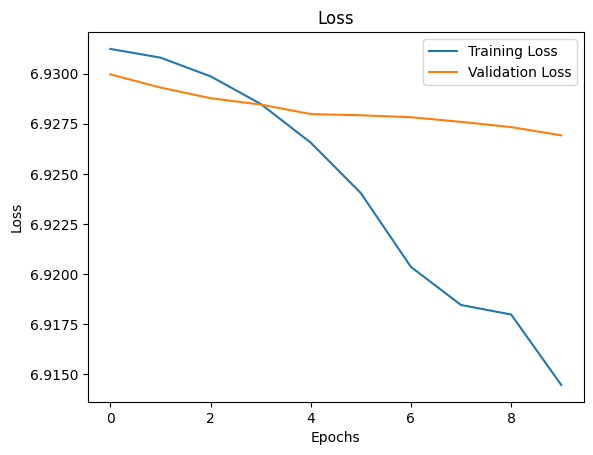

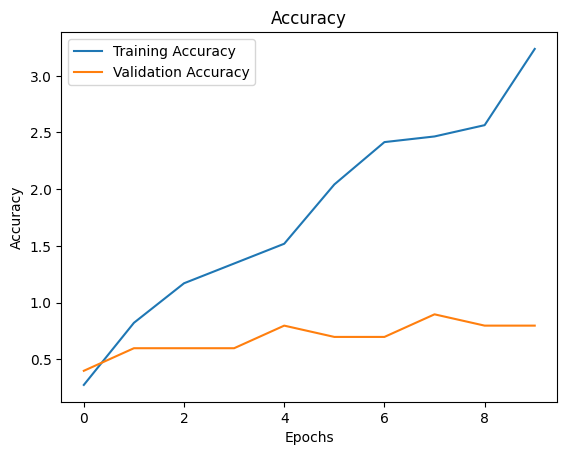

In [16]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)
plot_accuracy(train_acc,val_acc)